In [1]:
!nvidia-smi

Tue Aug 29 00:51:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:06:00.0 Off |                    0 |
| N/A   58C    P0   297W / 300W |   1833MiB / 32768MiB |     42%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:07:00.0 Off |                    0 |
| N/A   

In [2]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.set_device(4)


/home/sur06423/miniconda3/envs/vi_trans/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
print('GPU device:',torch.cuda.get_device_name())

GPU device: Tesla V100-SXM2-32GB


In [2]:
import torch


if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU device:',torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print('No GPU avaialable, Using CPU')

torch.cuda.set_device(0)

/home/sur06423/miniconda3/envs/vi_trans/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU device: Tesla V100-SXM2-32GB


In [3]:
from torch import nn
import torchvision
from torchinfo import summary
import sys
sys.path.append('/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline')


/home/sur06423/miniconda3/envs/vi_trans/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/sur06423/miniconda3/envs/vi_trans/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # DEFAULT means the best available weights
pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

In [5]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         #col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [6]:
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

In [7]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         #col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  False
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 19

In [8]:
# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# Change the classifier head (set the seeds to ensure same initialization with linear head)
pretrained_vit.heads = nn.Linear(in_features=768, out_features=34).to(device)
# pretrained_vit # uncomment for model output 


In [9]:
summary(model=pretrained_vit, 
         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
         #col_names=["input_size"], # uncomment for smaller output
         col_names=["input_size", "output_size", "num_params", "trainable"],
         col_width=20,
         row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 34]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

# Preparing Data for the pretrained ViT Model imported from torchvision.models

In [10]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [11]:
image_path = "/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/daa_dataset/"
train_dir = "/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/daa_dataset/train"
test_dir = "/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/daa_dataset/test"
val_dir = "/home/sur06423/hiwi/vit_exp/vision_tranformer_baseline/daa_dataset/val"

In [12]:
from src.components import data_setup
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224
BATCH_SIZE = 16

train_dataloader, test_dataloader , val_dataloader, class_names = data_setup.create_dataloaders(
    train_dir= train_dir,
    test_dir=test_dir,
    val_dir = val_dir,
    transform=pretrained_vit_transforms,
    batch_size=BATCH_SIZE,
    num_workers= 4,
)

train_dataloader, test_dataloader, val_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fa713b17e50>,
 ['closing_bottle',
  'closing_door_inside',
  'closing_door_outside',
  'closing_laptop',
  'drinking',
  'eating',
  'entering_car',
  'exiting_car',
  'fastening_seat_belt',
  'fetching_an_object',
  'interacting_with_phone',
  'looking_or_moving_around (e.g. searching)',
  'opening_backpack',
  'opening_bottle',
  'opening_door_inside',
  'opening_door_outside',
  'opening_laptop',
  'placing_an_object',
  'preparing_food',
  'pressing_automation_button',
  'putting_laptop_into_backpack',
  'putting_on_jacket',
  'putting_on_sunglasses',
  'reading_magazine',
  'reading_newspaper',
  'sitting_still',
  'taking_laptop_from_backpack',
  'taking_off_jacket',
  'taking_off_sunglasses',
  'talking_on_phone',
  'unfastening_seat_belt',
  'using_multimedia_display',
  'working_on_laptop',
  'writing'])

In [13]:
len(train_dataloader), len(test_dataloader), len(val_dataloader)

(16242, 5458, 3502)

In [14]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(23))

In [15]:
image_batch.shape , label_batch.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [16]:
label_batch

tensor([23,  4, 23,  5, 16, 25, 10, 25, 33, 17,  5, 17, 33, 11,  0, 24])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


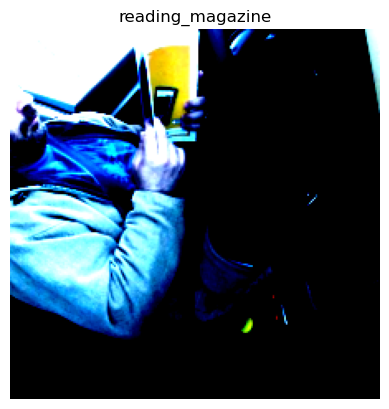

In [17]:
import matplotlib.pyplot as plt
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [18]:
image_1 = image.unsqueeze(0)
image_1.shape
image_1.to(device)

tensor([[[[ 2.1804,  2.1633,  2.1462,  ...,  1.0844,  1.0844,  1.1358],
          [ 2.1804,  2.1804,  2.1804,  ...,  1.0673,  1.0844,  1.1015],
          [ 2.1804,  2.1975,  2.1975,  ...,  1.0673,  1.1015,  1.0673],
          ...,
          [-1.9980, -1.9980, -2.0152,  ..., -2.0152, -2.0152, -2.0494],
          [-2.0323, -2.0152, -2.0152,  ..., -1.9980, -1.9980, -2.0152],
          [-1.9980, -1.9980, -2.0152,  ..., -2.0152, -2.0152, -2.0152]],

         [[ 2.3936,  2.3936,  2.4111,  ...,  1.4307,  1.4307,  1.4832],
          [ 2.3936,  2.3936,  2.3936,  ...,  1.4132,  1.4307,  1.4482],
          [ 2.3936,  2.3936,  2.3936,  ...,  1.3957,  1.4482,  1.4132],
          ...,
          [-1.8256, -1.8256, -1.8431,  ..., -1.9132, -1.9132, -1.9307],
          [-1.8606, -1.8431, -1.8431,  ..., -1.8782, -1.8782, -1.8957],
          [-1.8431, -1.8256, -1.8431,  ..., -1.8431, -1.8606, -1.8606]],

         [[ 2.6051,  2.5877,  2.5529,  ...,  1.4548,  1.4548,  1.5071],
          [ 2.6051,  2.5877,  

In [19]:
prediction = pretrained_vit(image_1.to(device))

In [20]:
prediction.shape

torch.Size([1, 34])

In [21]:
prediction

tensor([[ 1.0182,  0.4718, -0.2339,  0.5946, -0.3584, -0.1540,  0.5902,  0.3808,
          1.0384, -0.4482,  0.1677, -0.4279, -0.2841,  0.8211,  0.3660, -0.4879,
          0.3979, -0.0099, -0.4680, -0.0941, -0.6405, -0.3465, -0.6842, -0.8331,
          0.3865,  1.2983,  0.4304,  0.0750,  0.4485,  0.1520, -0.4378,  0.3681,
         -0.4645, -0.0319]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [22]:
random_ground_truth = torch.randint(0, 35, (1,16))
random_ground_truth

tensor([[14, 10, 16,  1, 32, 19, 26, 14, 26, 23, 14, 21,  0, 20,  3, 32]])

In [23]:
random_ground_truth = random_ground_truth.squeeze(dim=0)
random_ground_truth.shape

torch.Size([16])

In [24]:
prediction_cpu = prediction.detach().cpu()
# Apply the softmax operation on logits to get probabilities
prediction_cpu = torch.softmax(prediction_cpu, dim=1)
# Get the index of the maximum predicted class probability
prediction_cpu = torch.argmax(prediction_cpu, dim=1)
prediction_cpu

tensor([25])

In [25]:
image_batch.shape
label_batch.shape

torch.Size([16])

In [26]:
label_batch

tensor([16, 21, 17, 28, 25, 33, 21, 25, 25, 17, 25, 24,  5, 25,  5, 27])

In [27]:
prediction_batch = pretrained_vit(image_batch.to(device))

In [28]:
prediction_batch.shape

torch.Size([16, 34])

In [29]:
prediction_batch

tensor([[ 1.0182e+00,  4.7178e-01, -2.3391e-01,  5.9455e-01, -3.5845e-01,
         -1.5402e-01,  5.9024e-01,  3.8083e-01,  1.0384e+00, -4.4821e-01,
          1.6768e-01, -4.2791e-01, -2.8412e-01,  8.2105e-01,  3.6599e-01,
         -4.8792e-01,  3.9788e-01, -9.9193e-03, -4.6796e-01, -9.4111e-02,
         -6.4046e-01, -3.4654e-01, -6.8424e-01, -8.3305e-01,  3.8649e-01,
          1.2983e+00,  4.3036e-01,  7.4964e-02,  4.4853e-01,  1.5199e-01,
         -4.3784e-01,  3.6812e-01, -4.6448e-01, -3.1878e-02],
        [ 4.0574e-01,  5.8288e-01, -5.6272e-01,  6.5597e-01, -3.2681e-01,
          1.0326e-01,  8.7111e-01,  5.3475e-01,  6.4218e-01, -6.9271e-01,
          1.8250e-02, -4.6030e-01, -6.3614e-01,  5.3169e-01,  2.6933e-01,
         -2.2175e-01,  4.1913e-01,  3.7943e-01, -1.7158e-01,  1.4899e-01,
         -5.7086e-01, -3.4432e-01, -4.4123e-01, -2.4481e-01,  5.3577e-01,
          9.8042e-01,  5.4902e-01,  5.4308e-02,  3.5290e-01, -1.3367e-01,
          4.6108e-03,  6.7774e-01, -5.7943e-01, -3

In [46]:
import torch
from sklearn.metrics import accuracy_score, balanced_accuracy_score

prediction_batch = torch.tensor([33, 21, 23,  8, 10,  10,  5,  15, 25,  9, 23,  15, 32, 21, 23,  8])
prediction_batch_cpu = prediction_batch.detach().cpu()

label_batch = torch.tensor([33, 21, 25,  8, 10,  0,  5,  5, 25,  9, 23,  5, 32, 21, 23,  8])
# Convert tensors to numpy arrays if needed
label_batch_numpy = label_batch.numpy() if isinstance(label_batch, torch.Tensor) else label_batch

# Calculate accuracy using sklearn metrics
acc_sk = accuracy_score(label_batch_numpy, prediction_batch_cpu.numpy())
print(f"The accuracy score according to sklearn metrics is {acc_sk}")

bal_acc_sk = balanced_accuracy_score(label_batch_numpy, prediction_batch_cpu.numpy())
print(f"The balanced accuracy score according to sklearn metrics is {bal_acc_sk}")

The accuracy score according to sklearn metrics is 0.75
The balanced accuracy score according to sklearn metrics is 0.7833333333333334


/home/sur06423/miniconda3/envs/vi_trans/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [43]:
train_acc = 0
y_pred_class = torch.tensor([33, 21, 23,  8, 10,  10,  5,  15, 25,  9, 23,  15, 32, 21, 23,  8])
y = torch.tensor([33, 21, 25,  8, 10,  0,  5,  5, 25,  9, 23,  5, 32, 21, 23,  8])
train_acc += (y_pred_class == y).sum().item()/len(y_pred)

In [44]:
train_acc

0.75

In [35]:
train_acc = train_acc / len(dataloader)

34

In [36]:
import numpy as np

def calculate_metrics(y_true, y_pred, num_classes):
    true_positives = [0] * num_classes
    true_negatives = [0] * num_classes
    false_positives = [0] * num_classes
    false_negatives = [0] * num_classes
    
    for true_label, pred_label in zip(y_true, y_pred):
        if 0 <= pred_label < num_classes:
            if true_label == pred_label:
                true_positives[true_label] += 1
                for i in range(num_classes):
                    if i != true_label:
                        true_negatives[i] += 1
            else:
                false_positives[pred_label] += 1
                false_negatives[true_label] += 1
    
    sensitivity = [tp / (tp + fn) if (tp + fn) != 0 else 0 for tp, fn in zip(true_positives, false_negatives)]
    specificity = [tn / (tn + fp) if (tn + fp) != 0 else 0 for tn, fp in zip(true_negatives, false_positives)]
    
    accuracy = sum(true_positives) / len(y_true)
    
    precision = [tp / (tp + fp) if (tp + fp) != 0 else 0 for tp, fp in zip(true_positives, false_positives)]
    recall = sensitivity
    f1_score = [2 * (prec * rec) / (prec + rec) if (prec + rec) != 0 else 0 for prec, rec in zip(precision, recall)]
    
    confusion_matrix = np.array([
        [true_positives[i], false_positives[i]],
        [false_negatives[i], true_negatives[i]]
    ] for i in range(num_classes))
    
    balanced_accuracy = sum([(sens + spec) / 2 for sens, spec in zip(sensitivity, specificity)]) / num_classes
    
    return {
        "True Positives": true_positives,
        "True Negatives": true_negatives,
        "False Positives": false_positives,
        "False Negatives": false_negatives,
        "Sensitivity": sensitivity,
        "Specificity": specificity,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score,
        "Confusion Matrix": confusion_matrix,
        "Balanced Accuracy": balanced_accuracy
    }

# Example data
# tensor([25,  5, 25, 29, 25, 25, 25,  4, 25, 25, 10, 25, 18,  9, 10, 33])
# y_true = [17, 25, 25, 9, 5, 21, 17, 29, 25, 10, 17, 25, 25, 24, 24, 23]
y_true = [25,  5, 25, 29, 25, 25, 25,  4, 25, 25, 10, 25, 18,  9, 10, 33]
# y_pred = [17, 18, 25, 33, 5, 21, 18, 0, 18, 18, 25, 18, 24, 18, 24, 23]
y_pred = [25,  5, 25, 29, 25, 25, 25,  4, 25, 25, 10, 25, 18,  9, 10, 33]
num_classes = 34

metrics = calculate_metrics(y_true, y_pred, num_classes)
for metric, values in metrics.items():
    print(metric + ":", values)



True Positives: [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 1, 0, 0, 0, 1]
True Negatives: [16, 16, 16, 16, 15, 15, 16, 16, 16, 15, 14, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 8, 16, 16, 16, 15, 16, 16, 16, 15]
False Positives: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
False Negatives: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Sensitivity: [0, 0, 0, 0, 1.0, 1.0, 0, 0, 0, 1.0, 1.0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 1.0, 0, 0, 0, 1.0]
Specificity: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Accuracy: 1.0
Precision: [0, 0, 0, 0, 1.0, 1.0, 0, 0, 0, 1.0, 1.0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 1.0, 0, 0, 0, 1.0, 0, 0, 0, 1.0]
Recall: [0, 0, 0, 0, 1.0, 1.0

In [37]:
import torch

def calculate_metrics(y_true, y_pred, num_classes):
    true_positives = torch.zeros(num_classes)
    true_negatives = torch.zeros(num_classes)
    false_positives = torch.zeros(num_classes)
    false_negatives = torch.zeros(num_classes)
    
    for true_label, pred_label in zip(y_true, y_pred):
        if 0 <= pred_label < num_classes:
            if true_label == pred_label:
                true_positives[true_label] += 1
                for i in range(num_classes):
                    if i != true_label:
                        true_negatives[i] += 1
            else:
                false_positives[pred_label] += 1
                false_negatives[true_label] += 1
    
    sensitivity = true_positives / (true_positives + false_negatives).clamp(min=1e-6)
    specificity = true_negatives / (true_negatives + false_positives).clamp(min=1e-6)
    
    accuracy = true_positives.sum() / len(y_true)
    
    precision = true_positives / (true_positives + false_positives).clamp(min=1e-6)
    recall = sensitivity
    f1_score = 2 * (precision * recall) / (precision + recall).clamp(min=1e-6)
    
    confusion_matrix = torch.stack([
        torch.stack([true_positives, false_positives]),
        torch.stack([false_negatives, true_negatives])
    ])
    
    balanced_accuracy = ((sensitivity + specificity) / 2).sum() / num_classes
    
    return {
        "True Positives": true_positives.tolist(),
        "True Negatives": true_negatives.tolist(),
        "False Positives": false_positives.tolist(),
        "False Negatives": false_negatives.tolist(),
        "Sensitivity": sensitivity.tolist(),
        "Specificity": specificity.tolist(),
        "Accuracy": accuracy.item(),
        "Precision": precision.tolist(),
        "Recall": recall.tolist(),
        "F1 Score": f1_score.tolist(),
        "Confusion Matrix": confusion_matrix.tolist(),
        "Balanced Accuracy": balanced_accuracy.item()
    }

# Example data
y_true = [17, 25, 25, 9, 5, 21, 17, 29, 25, 10, 17, 25, 25, 24, 24, 23]
y_pred = [17, 18, 25, 33, 5, 21, 18, 0, 18, 18, 25, 18, 24, 18, 24, 23]
num_classes = 34

metrics = calculate_metrics(y_true, y_pred, num_classes)
for metric, values in metrics.items():
    print(metric + ":", values)

True Positives: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
True Negatives: [6.0, 6.0, 6.0, 6.0, 6.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 5.0, 6.0, 6.0, 6.0, 5.0, 6.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]
False Positives: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
False Negatives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 4.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
Sensitivity: [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333432674408, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.5, 0.20000000298023224, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Specificity: [0.8571428656578064, 1

In [38]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
# random_ground_truth_numpy, prediction_batch_cpu.numpy()
y_true_sk = [17, 25, 25, 9, 5, 21, 17, 29, 25, 10, 17, 25, 25, 24, 24, 23]
y_pred_sk = [17, 18, 25, 33, 5, 21, 18, 0, 18, 18, 25, 18, 24, 18, 24, 23]
acc = accuracy_score(y_true_sk, y_pred_sk)
bal_acc = balanced_accuracy_score(y_true_sk, y_pred_sk)
acc, bal_acc

/home/sur06423/miniconda3/envs/vi_trans/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(0.375, 0.44814814814814813)

In [39]:
y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
train_acc += (y_pred_class == y).sum().item()/len(y_pred)

TypeError: softmax() received an invalid combination of arguments - got (list, dim=int), but expected one of:
 * (Tensor input, int dim, torch.dtype dtype, *, Tensor out)
 * (Tensor input, name dim, *, torch.dtype dtype)


In [ ]:
import torch
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# Assuming `random_ground_truth` is a numpy array or tensor containing ground truth labels

# Move prediction tensor to CPU
prediction_cpu = prediction.detach().cpu()
prediction_cpu = torch.softmax(prediction_cpu, dim=1)

# Convert tensors to numpy arrays if needed
random_ground_truth_numpy = random_ground_truth.numpy() if isinstance(random_ground_truth, torch.Tensor) else random_ground_truth

# Calculate accuracy using sklearn metrics
acc_sk = accuracy_score(random_ground_truth_numpy, prediction_cpu.numpy()) # prediction_cpu.argmax(dim=1).numpy()
print(f"The accuracy score according to sklearn metrics is {acc_sk}")



ValueError: Classification metrics can't handle a mix of multiclass-multioutput and continuous-multioutput targets

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
acc_sk = accuracy_score(random_ground_truth, prediction)
print(f"The accuracy score according to sklearn metrics is  {acc_sk}")

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.